# CSC424 - Machine Learning - Assignment 3

<br>

### Team - Random Access Memories
> #### Rivu Bhattacharjee — 1910626
> #### Ahnaf Abdullah — 2130223
> #### Tausia Tahsin Nuzum — 2221415



## Problems

#### Assignment 3 | Due 17/11/2024 (Forward pass: 50% + Backward pass 50%)

1. Now we will design a simple convolutional neural network for classification. Use MNIST 10 dataset with 10 classes.

2. You need to write codes to implement the following architecture with PyTorch

3. Initialize the parameters with Xavier initialization.

4. Use batch normalization and sigmoid activation function for fully connected layers .

5. Use adam optimizer with default settings.

6. Plot training loss, validation loss for learning rate 0.001 and batch size: 1024.

7. Run the test on the test split and report confusion matrix and the F1 scores for your test data


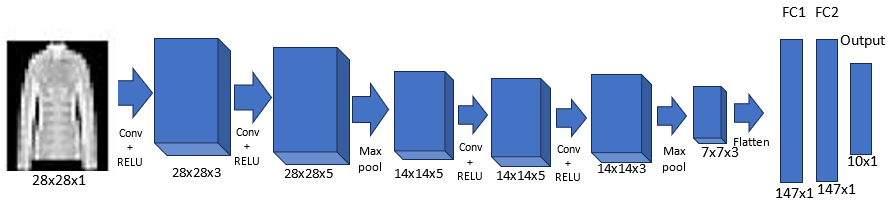

## Setup



### Imports and Defines

In [ ]:
import os         # file en
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

from tqdm.notebook import tqdm
import yaml
from PIL import Image
from sklearn.metrics import (ConfusionMatrixDisplay, classification_report,
                             confusion_matrix, f1_score)
from sklearn.model_selection import train_test_split

from google.colab import files   # download file programatically when done
import pickle

### Helper Functions



In [ ]:
def show_image(img_arr: np.array, shape=(28, 28), label=None, boxborder=True):
    """A highly customizable plotter function that renders a single greyscale image. """
    plt.figure(figsize=(2, 2))
    #
    if boxborder:
      plt.gca().set_xticks([])
      plt.gca().set_yticks([])
      plt.gca().spines[:].set_visible(True)
    else:
      plt.axis('off')

    plt.imshow(img_arr.reshape(shape), cmap="Greys")
    if label is not None:
        plt.title(label)
    plt.show()

In [ ]:
def LABEL_MAP(index: int) -> str:
  """Maps every index number representing a class in the Fashion MNIST dataset to the name of the class(i.e string)"""
  label_map: dict = {
      0: "T-shirt/top",
      1: "Trouser",
      2: "Pullover",
      3: "Dress",
      4: "Coat",
      5: "Sandal",
      6: "Shirt",
      7: "Sneaker",
      8: "Bag",
      9: "Ankle boot"
  }

  try:
    return label_map[index]
  except KeyError:
    raise KeyError("{} does not represent a valid class!".format(index)) from None

print(LABEL_MAP(4))

Coat


In [ ]:
def show_ConfusionMatrix(test_labels, predicted_labels, title: str):
    """Renders a confusion matrix based on the test labels loaded by the
    dataloader, and predicted labels resulting from the output of some classifier. """
    class_names = [LABEL_MAP(i) for i in range(10)]
    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(test_labels, predicted_labels), display_labels=class_names)
    disp = disp.plot(xticks_rotation=45)
    plt.title('Confusion Matrix: {}'.format(title))
    plt.show()

## Assignment 3



---



---



In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load and preprocess the Fashion MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Download the dataset
full_train_data = datasets.FashionMNIST(root='data', train=True, download=True, transform=transform)
full_test_data = datasets.FashionMNIST(root='data', train=False, download=True, transform=transform)

# Split into train, validation, and test

train_size = int(0.8 * len(full_train_data)) #48000 images for training
val_size = int(0.2 * len(full_train_data))   #12000 images for validation
test_size = len(full_test_data)              #10000 images for testing
train_data, val_data= random_split(full_train_data, [train_size, val_size])
test_data = full_test_data

print("Training images:", len(train_data))
print("Validation images:", len(val_data))
print("Testing images:", len(test_data))

# DataLoaders
batch_size = 1024
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

100%|██████████| 26.4M/26.4M [00:01<00:00, 17.8MB/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 308kB/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:00<00:00, 4.89MB/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 23.5MB/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw

Training images: 48000
Validation images: 12000
Testing images: 10000


In [ ]:
# Define the CNN architecture with Xavier initialization
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 3, kernel_size=3, padding=1)  # 28x28x3, zero-padded
        self.conv2 = nn.Conv2d(3, 5, kernel_size=3, padding=1)  # 28x28x5, zero-padded
        self.conv3 = nn.Conv2d(5, 5, kernel_size=3, padding=1)  # 14x14x5, zero-padded
        self.conv4 = nn.Conv2d(5, 3, kernel_size=3, padding=1)  # 14x14x3, zero-padded

        # Dropouts on the fully connected layers
        self.dropout1 = nn.Dropout(0.4)

        # Fully connected layers
        self.fc1 = nn.Linear(7 * 7 * 3, 147)
        self.fc2 = nn.Linear(147, 10)

        # Initialize weights with Xavier initialization
        nn.init.xavier_uniform_(self.conv1.weight)
        nn.init.xavier_uniform_(self.conv2.weight)
        nn.init.xavier_uniform_(self.conv3.weight)
        nn.init.xavier_uniform_(self.conv4.weight)
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)

        # Batch normalization layers for fully connected layers
        self.bn1 = nn.BatchNorm1d(147)

    def forward(self, x):
        # Convolutional layers with ReLU and Max Pooling
        x = F.relu(self.conv1(x))                  # 28x28x3
        x = F.relu(self.conv2(x))                  # 28x28x5
        x = F.max_pool2d(x, 2)                     # 14x14x5
        x = F.relu(self.conv3(x))                  # 14x14x5
        x = F.relu(self.conv4(x))                  # 14x14x3
        x = F.max_pool2d(x, 2)                     # 7x7x3

        # Flatten
        x = x.view(-1, 7 * 7 * 3)                  # 147

        # Fully connected layers with BatchNorm and Sigmoid activation
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.dropout1(x)
        x = torch.sigmoid(x)
        x = self.fc2(x)                            # Output layer (10 classes)
        return x

# Model, criterion, and optimizer
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Testing:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Testing:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Testing:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Testing:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Testing:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Testing:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Testing:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Testing:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Testing:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Testing:   0%|          | 0/12 [00:00<?, ?it/s]

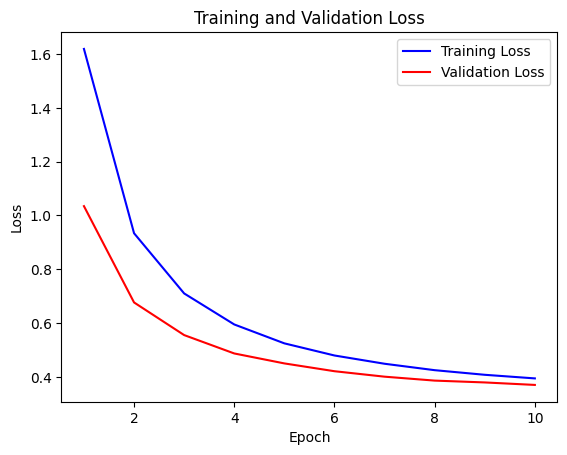

In [ ]:
# Training and validation

def train(epochs):
    train_losses, val_losses = [], []

    epoch_loop = tqdm(range(epochs), desc="Epoch")
    for epoch in epoch_loop:
        # Training
        with tqdm(total=len(train_loader), desc="Training: ", leave=False) as train_loop:
            model.train()
            running_train_loss = 0
            for images, labels in train_loader:
                images, labels = images.to(device), labels.to(device)

                # Forward pass
                outputs = model(images)
                loss = criterion(outputs, labels)

                # Backward and optimize
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                running_train_loss += loss.item()
                train_loop.update(1)

        train_losses.append(running_train_loss / len(train_loader))

        # Validation
        with tqdm(total=len(val_loader), desc="Testing: ", leave=False) as test_loop:
            model.eval()
            running_val_loss = 0
            with torch.no_grad():
                for images, labels in val_loader:
                    images, labels = images.to(device), labels.to(device)
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                    running_val_loss += loss.item()
                    test_loop.update(1)

        val_losses.append(running_val_loss / len(val_loader))
        epoch_loop.set_postfix_str(f"Train Loss: {train_losses[-1]:.4f}, Validation Loss: {val_losses[-1]:.4f}")

    return train_losses, val_losses


# Train for 10 epochs
epochs = 10
train_losses, val_losses = train(epochs)

# Plot the training and validation losses
plt.plot(range(1, epochs + 1), train_losses, label="Training Loss", color="blue")
plt.plot(range(1, epochs + 1), val_losses, label="Validation Loss", color="red")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()


In [ ]:
def test(test_loader):
    # Evaluate on test data
    model.eval()
    all_preds = []
    all_labels = []

    with tqdm(total=len(test_loader), desc="Testing: ") as test_loop:
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, preds = torch.max(outputs, 1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                test_loop.update(1)

    return all_preds, all_labels

test_pred, test_labels = test(test_loader)

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

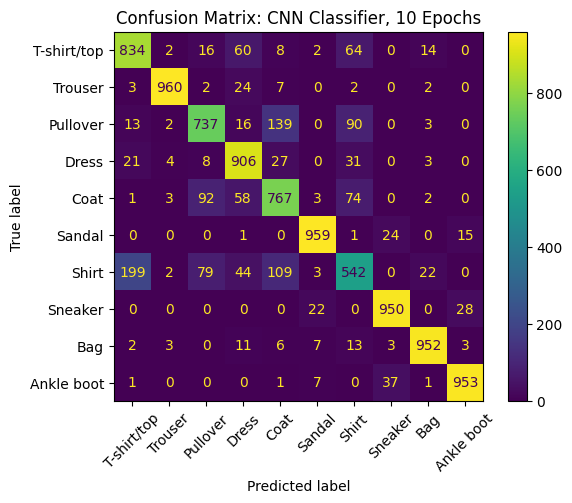


	CNN Classifier, 10 Epochs

              precision    recall  f1-score   support

 T-shirt/top       0.78      0.83      0.80      1000
     Trouser       0.98      0.96      0.97      1000
    Pullover       0.79      0.74      0.76      1000
       Dress       0.81      0.91      0.85      1000
        Coat       0.72      0.77      0.74      1000
      Sandal       0.96      0.96      0.96      1000
       Shirt       0.66      0.54      0.60      1000
     Sneaker       0.94      0.95      0.94      1000
         Bag       0.95      0.95      0.95      1000
  Ankle boot       0.95      0.95      0.95      1000

    accuracy                           0.86     10000
   macro avg       0.85      0.86      0.85     10000
weighted avg       0.85      0.86      0.85     10000



In [ ]:
# Performance after 10 epochs, model is converging to a high accuracy value very fast!
show_ConfusionMatrix(test_labels, test_pred, "CNN Classifier, 10 Epochs")

print('\n\tCNN Classifier, 10 Epochs\n')
print(classification_report(test_labels, test_pred, target_names=[LABEL_MAP(i) for i in range(10)]))

Epoch:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Testing:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Testing:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Testing:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Testing:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Testing:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Testing:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Testing:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Testing:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Testing:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Testing:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Testing:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Testing:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Testing:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Testing:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Testing:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Testing:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Testing:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Testing:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Testing:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Testing:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Testing:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Testing:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Testing:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Testing:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Testing:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Testing:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Testing:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Testing:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Testing:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Testing:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Testing:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Testing:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Testing:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Testing:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Testing:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Testing:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Testing:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Testing:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Testing:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Testing:   0%|          | 0/12 [00:00<?, ?it/s]

Training done


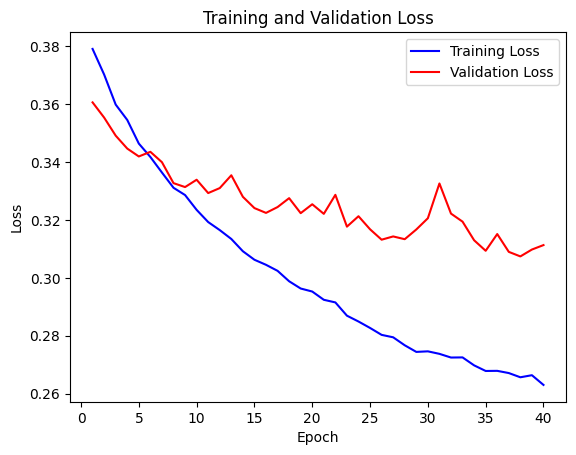

In [ ]:
# Train for 50 epochs
epochs = 40
train_losses, val_losses = train(epochs)
print("Training done")

# Plot the training and validation losses
plt.plot(range(1, epochs + 1), train_losses, label="Training Loss", color="blue")
plt.plot(range(1, epochs + 1), val_losses, label="Validation Loss", color="red")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

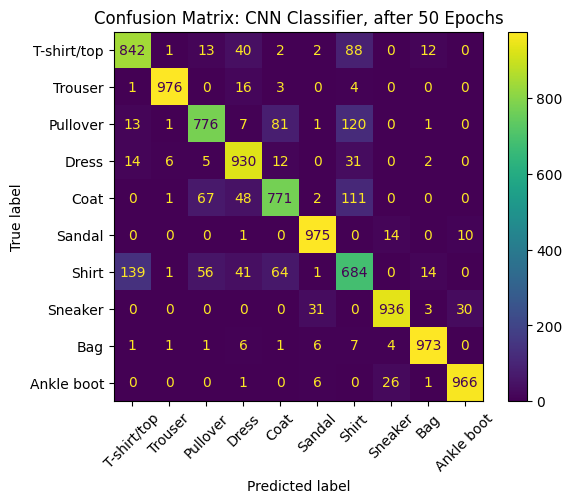


	CNN Classifier, after 50 Epochs

              precision    recall  f1-score   support

 T-shirt/top       0.83      0.84      0.84      1000
     Trouser       0.99      0.98      0.98      1000
    Pullover       0.85      0.78      0.81      1000
       Dress       0.85      0.93      0.89      1000
        Coat       0.83      0.77      0.80      1000
      Sandal       0.95      0.97      0.96      1000
       Shirt       0.65      0.68      0.67      1000
     Sneaker       0.96      0.94      0.95      1000
         Bag       0.97      0.97      0.97      1000
  Ankle boot       0.96      0.97      0.96      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



In [ ]:
torch.save(model.state_dict(), "model_CNNClassifier.pt")      # Save model to disk

# # Load model from disk
#model = CNN(*args, **kwargs)
#model.load_state_dict(torch.load("model_CNNClassifier.pt", weights_only=True))
#model.eval()

test_pred, test_labels = test(test_loader)
# Performance after 10 epochs, model is converging to a high accuracy value very fast!
show_ConfusionMatrix(test_labels, test_pred, "CNN Classifier, after 50 Epochs")

print('\n\tCNN Classifier, after 50 Epochs\n')
print(classification_report(test_labels, test_pred, target_names=[LABEL_MAP(i) for i in range(10)]))

Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Testing:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Testing:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Testing:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Testing:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Testing:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Testing:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Testing:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Testing:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Testing:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Testing:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Testing:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Testing:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Testing:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Testing:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Testing:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Testing:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Testing:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Testing:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Testing:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Testing:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Testing:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Testing:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Testing:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Testing:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Testing:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Testing:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Testing:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Testing:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Testing:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Testing:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Testing:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Testing:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Testing:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Testing:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Testing:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Testing:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Testing:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Testing:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Testing:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Testing:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Testing:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Testing:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Testing:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Testing:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Testing:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Testing:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Testing:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Testing:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Testing:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Testing:   0%|          | 0/12 [00:00<?, ?it/s]

Training done


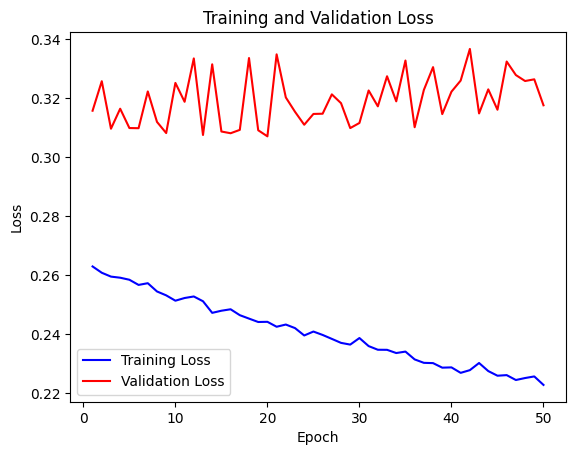

In [ ]:
# Train for 50 more epochs, totalling to 100
epochs = 50
train_losses, val_losses = train(epochs)
print("Training done")

# Plot the training and validation losses
plt.plot(range(1, epochs + 1), train_losses, label="Training Loss", color="blue")
plt.plot(range(1, epochs + 1), val_losses, label="Validation Loss", color="red")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

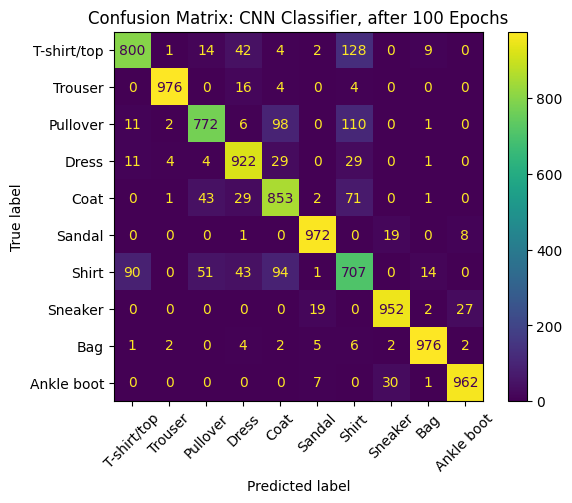


	CNN Classifier, after 100 Epochs

              precision    recall  f1-score   support

 T-shirt/top       0.88      0.80      0.84      1000
     Trouser       0.99      0.98      0.98      1000
    Pullover       0.87      0.77      0.82      1000
       Dress       0.87      0.92      0.89      1000
        Coat       0.79      0.85      0.82      1000
      Sandal       0.96      0.97      0.97      1000
       Shirt       0.67      0.71      0.69      1000
     Sneaker       0.95      0.95      0.95      1000
         Bag       0.97      0.98      0.97      1000
  Ankle boot       0.96      0.96      0.96      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



In [ ]:
test_pred, test_labels = test(test_loader)
show_ConfusionMatrix(test_labels, test_pred, "CNN Classifier, after 100 Epochs")

print('\n\tCNN Classifier, after 100 Epochs\n')
print(classification_report(test_labels, test_pred, target_names=[LABEL_MAP(i) for i in range(10)]))